In [72]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics import Accuracy, ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from pathlib import Path

In [2]:
## Download train and test data

In [3]:
train_data = datasets.FashionMNIST(root='FashionMNIST_data',
                                   train=True,
                                   transform=ToTensor(),
                                   target_transform=None,
                                   download=True)

test_data = datasets.FashionMNIST(root='FashionMNIST_data',
                                  train=False,
                                  transform=ToTensor(),
                                  target_transform=None,
                                  download=True)

In [4]:
print(f"Length of train data : {len(train_data)}")
print(f"Length of test data : {len(test_data)}")

Length of train data : 60000
Length of test data : 10000


In [5]:
label_class = train_data.class_to_idx
label_class

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [6]:
## train and test dataloader

In [7]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=True)

In [8]:
train_dataloader.batch_size

32

In [9]:
len(train_dataloader)

1875

In [10]:
train_dataloader

In [11]:
next(iter(train_dataloader))

[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000

In [12]:
## visualize data

(-0.5, 27.5, 27.5, -0.5)

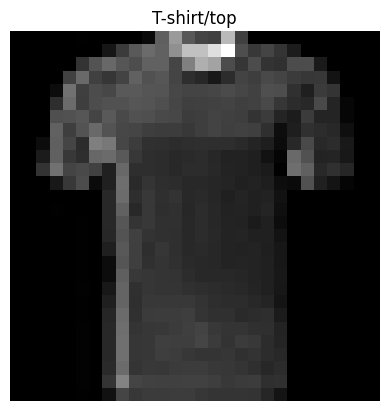

In [13]:
train_feature_batch, train_label_batch = next(iter(train_dataloader))
random_idx = torch.randint(low=0, high=len(train_feature_batch), size=[1]).item()
img, lbl = train_feature_batch[random_idx], train_label_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(list(label_class.keys())[lbl])
plt.axis(False)

In [14]:
## Build model

In [15]:
class FashionMNISTModel(nn.Module):
    def __init__(self,
                 in_feature,
                 hidden_units,
                 out_fetures):
        super().__init__()
        self.linear_stack = nn.Sequential(nn.Flatten(),
                                          nn.Linear(in_features=in_feature, out_features=hidden_units),
                                          nn.ReLU(),
                                          nn.Linear(in_features=hidden_units, out_features=out_fetures),
                                          nn.ReLU()
                                          )

    def forward(self, X :torch.Tensor):
        return self.linear_stack(X)

In [16]:
model = FashionMNISTModel(in_feature=train_feature_batch.size()[1]*train_feature_batch.size()[2]*train_feature_batch.size()[3],
                          hidden_units=20,
                          out_fetures=10)

In [17]:
## Train/Test function

In [18]:
torch.manual_seed(42)

def train_model(model :torch.nn.Module,
                train_dataloader :DataLoader,
                loss_fn :nn.functional,
                acc_fn :nn.functional,
                optimizer :torch.optim):
    model.train()
    train_loss = 0
    train_acc = 0
    for X,y in train_dataloader:
        train_logits = model(X)
        train_loss += loss_fn(train_logits, y)
        train_pred = torch.softmax(train_logits, dim=1).argmax(dim=1)
        train_acc += acc_fn(train_pred, y)
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    return train_loss, train_acc*100


def eval_model(model :nn.Module,
               test_dataloader :DataLoader,
               loss_fn :nn.functional,
               acc_fn :nn.functional):
    model.eval()
    with torch.inference_mode():
        test_loss = 0
        test_acc = 0
        for X,y in test_dataloader:
            test_logits = model(X)
            test_loss += loss_fn(test_logits, y)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
            test_acc += acc_fn(test_pred, y)
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        return test_loss, test_acc*100

In [19]:
## Train/Test loop

In [70]:
torch.manual_seed(42)

# define accuracy function
acc_fn = Accuracy(task='multiclass',
                  num_classes=10)

# define loss function
loss_fn = nn.CrossEntropyLoss()

# define optimizer
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.05)

epochs = 500
epoch_values = []
train_loss_values = []
test_loss_values = []

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_model(model,
                                        train_dataloader,
                                        loss_fn,
                                        acc_fn,
                                        optimizer)
    
    test_loss, test_acc = eval_model(model,
                                     test_dataloader,
                                     loss_fn,
                                     acc_fn)
    if epoch%10==0:
        print(f"Epoch : {epoch} | Train_loss : {train_loss :.3f} | Train_acc : {train_acc :.2f}% | Test_loss : {test_loss :.3f} | test_acc : {test_acc :.2f}%")
        epoch_values.append(epoch)
        train_loss_values.append(train_loss)
        test_loss_values.append(test_loss)

  0%|          | 1/500 [00:02<18:41,  2.25s/it]

Epoch : 0 | Train_loss : 1.192 | Train_acc : 55.63% | Test_loss : 1.212 | test_acc : 54.79%


  2%|▏         | 11/500 [00:25<18:52,  2.32s/it]

Epoch : 10 | Train_loss : 1.190 | Train_acc : 55.68% | Test_loss : 1.211 | test_acc : 54.81%


  4%|▍         | 21/500 [00:49<18:38,  2.34s/it]

Epoch : 20 | Train_loss : 1.189 | Train_acc : 55.70% | Test_loss : 1.210 | test_acc : 54.81%


  6%|▌         | 31/500 [01:11<17:42,  2.27s/it]

Epoch : 30 | Train_loss : 1.187 | Train_acc : 55.73% | Test_loss : 1.207 | test_acc : 54.91%


  8%|▊         | 41/500 [01:34<17:37,  2.30s/it]

Epoch : 40 | Train_loss : 1.186 | Train_acc : 55.76% | Test_loss : 1.207 | test_acc : 54.87%


 10%|█         | 51/500 [01:57<16:55,  2.26s/it]

Epoch : 50 | Train_loss : 1.184 | Train_acc : 55.78% | Test_loss : 1.206 | test_acc : 54.92%


 12%|█▏        | 61/500 [02:20<17:01,  2.33s/it]

Epoch : 60 | Train_loss : 1.183 | Train_acc : 55.82% | Test_loss : 1.205 | test_acc : 54.99%


 14%|█▍        | 71/500 [02:46<19:50,  2.77s/it]

Epoch : 70 | Train_loss : 1.182 | Train_acc : 55.86% | Test_loss : 1.204 | test_acc : 54.97%


 16%|█▌        | 81/500 [03:13<18:39,  2.67s/it]

Epoch : 80 | Train_loss : 1.180 | Train_acc : 55.91% | Test_loss : 1.202 | test_acc : 55.06%


 18%|█▊        | 91/500 [03:42<20:06,  2.95s/it]

Epoch : 90 | Train_loss : 1.179 | Train_acc : 55.94% | Test_loss : 1.200 | test_acc : 55.05%


 20%|██        | 101/500 [04:10<18:29,  2.78s/it]

Epoch : 100 | Train_loss : 1.178 | Train_acc : 55.97% | Test_loss : 1.200 | test_acc : 55.07%


 22%|██▏       | 111/500 [04:40<18:51,  2.91s/it]

Epoch : 110 | Train_loss : 1.176 | Train_acc : 56.00% | Test_loss : 1.199 | test_acc : 55.09%


 24%|██▍       | 121/500 [05:10<20:20,  3.22s/it]

Epoch : 120 | Train_loss : 1.175 | Train_acc : 56.02% | Test_loss : 1.197 | test_acc : 55.13%


 26%|██▌       | 131/500 [05:40<18:17,  2.97s/it]

Epoch : 130 | Train_loss : 1.174 | Train_acc : 56.05% | Test_loss : 1.196 | test_acc : 55.12%


 28%|██▊       | 141/500 [06:08<16:38,  2.78s/it]

Epoch : 140 | Train_loss : 1.173 | Train_acc : 56.08% | Test_loss : 1.196 | test_acc : 55.22%


 30%|███       | 151/500 [06:34<14:40,  2.52s/it]

Epoch : 150 | Train_loss : 1.172 | Train_acc : 56.11% | Test_loss : 1.196 | test_acc : 55.22%


 32%|███▏      | 161/500 [07:02<16:19,  2.89s/it]

Epoch : 160 | Train_loss : 1.171 | Train_acc : 56.13% | Test_loss : 1.194 | test_acc : 55.20%


 34%|███▍      | 171/500 [07:29<14:56,  2.73s/it]

Epoch : 170 | Train_loss : 1.170 | Train_acc : 56.13% | Test_loss : 1.192 | test_acc : 55.25%


 36%|███▌      | 181/500 [07:55<14:34,  2.74s/it]

Epoch : 180 | Train_loss : 1.168 | Train_acc : 56.16% | Test_loss : 1.192 | test_acc : 55.21%


 38%|███▊      | 191/500 [08:23<14:19,  2.78s/it]

Epoch : 190 | Train_loss : 1.167 | Train_acc : 56.19% | Test_loss : 1.190 | test_acc : 55.28%


 40%|████      | 201/500 [08:47<11:37,  2.33s/it]

Epoch : 200 | Train_loss : 1.166 | Train_acc : 56.21% | Test_loss : 1.190 | test_acc : 55.25%


 42%|████▏     | 211/500 [09:12<12:39,  2.63s/it]

Epoch : 210 | Train_loss : 1.165 | Train_acc : 56.22% | Test_loss : 1.189 | test_acc : 55.28%


 44%|████▍     | 221/500 [09:39<12:15,  2.64s/it]

Epoch : 220 | Train_loss : 1.164 | Train_acc : 56.24% | Test_loss : 1.188 | test_acc : 55.29%


 46%|████▌     | 231/500 [10:04<11:09,  2.49s/it]

Epoch : 230 | Train_loss : 1.163 | Train_acc : 56.25% | Test_loss : 1.188 | test_acc : 55.31%


 48%|████▊     | 241/500 [10:33<11:50,  2.74s/it]

Epoch : 240 | Train_loss : 1.162 | Train_acc : 56.28% | Test_loss : 1.186 | test_acc : 55.35%


 50%|█████     | 251/500 [10:57<09:36,  2.32s/it]

Epoch : 250 | Train_loss : 1.161 | Train_acc : 56.31% | Test_loss : 1.185 | test_acc : 55.40%


 52%|█████▏    | 261/500 [11:21<09:32,  2.40s/it]

Epoch : 260 | Train_loss : 1.161 | Train_acc : 56.33% | Test_loss : 1.184 | test_acc : 55.42%


 54%|█████▍    | 271/500 [11:45<09:39,  2.53s/it]

Epoch : 270 | Train_loss : 1.160 | Train_acc : 56.34% | Test_loss : 1.183 | test_acc : 55.47%


 56%|█████▌    | 281/500 [12:10<09:25,  2.58s/it]

Epoch : 280 | Train_loss : 1.159 | Train_acc : 56.37% | Test_loss : 1.183 | test_acc : 55.50%


 58%|█████▊    | 291/500 [12:33<07:59,  2.29s/it]

Epoch : 290 | Train_loss : 1.158 | Train_acc : 56.39% | Test_loss : 1.183 | test_acc : 55.50%


 60%|██████    | 301/500 [12:57<08:03,  2.43s/it]

Epoch : 300 | Train_loss : 1.157 | Train_acc : 56.42% | Test_loss : 1.182 | test_acc : 55.51%


 62%|██████▏   | 311/500 [13:19<07:06,  2.26s/it]

Epoch : 310 | Train_loss : 1.156 | Train_acc : 56.46% | Test_loss : 1.181 | test_acc : 55.47%


 64%|██████▍   | 321/500 [13:42<06:50,  2.29s/it]

Epoch : 320 | Train_loss : 1.155 | Train_acc : 56.48% | Test_loss : 1.181 | test_acc : 55.47%


 66%|██████▌   | 331/500 [14:05<06:18,  2.24s/it]

Epoch : 330 | Train_loss : 1.154 | Train_acc : 56.50% | Test_loss : 1.180 | test_acc : 55.48%


 68%|██████▊   | 341/500 [14:30<06:48,  2.57s/it]

Epoch : 340 | Train_loss : 1.154 | Train_acc : 56.52% | Test_loss : 1.178 | test_acc : 55.52%


 70%|███████   | 351/500 [14:53<06:07,  2.47s/it]

Epoch : 350 | Train_loss : 1.153 | Train_acc : 56.55% | Test_loss : 1.177 | test_acc : 55.51%


 72%|███████▏  | 361/500 [15:17<05:42,  2.47s/it]

Epoch : 360 | Train_loss : 1.152 | Train_acc : 56.56% | Test_loss : 1.178 | test_acc : 55.48%


 74%|███████▍  | 371/500 [15:41<04:59,  2.32s/it]

Epoch : 370 | Train_loss : 1.151 | Train_acc : 56.57% | Test_loss : 1.177 | test_acc : 55.49%


 76%|███████▌  | 381/500 [16:05<04:39,  2.35s/it]

Epoch : 380 | Train_loss : 1.150 | Train_acc : 56.58% | Test_loss : 1.176 | test_acc : 55.52%


 78%|███████▊  | 391/500 [16:30<04:41,  2.58s/it]

Epoch : 390 | Train_loss : 1.150 | Train_acc : 56.60% | Test_loss : 1.176 | test_acc : 55.53%


 80%|████████  | 401/500 [16:53<03:44,  2.27s/it]

Epoch : 400 | Train_loss : 1.149 | Train_acc : 56.60% | Test_loss : 1.174 | test_acc : 55.61%


 82%|████████▏ | 411/500 [17:17<03:30,  2.37s/it]

Epoch : 410 | Train_loss : 1.148 | Train_acc : 56.63% | Test_loss : 1.175 | test_acc : 55.56%


 84%|████████▍ | 421/500 [17:39<03:01,  2.29s/it]

Epoch : 420 | Train_loss : 1.147 | Train_acc : 56.64% | Test_loss : 1.174 | test_acc : 55.61%


 86%|████████▌ | 431/500 [18:04<02:45,  2.40s/it]

Epoch : 430 | Train_loss : 1.147 | Train_acc : 56.66% | Test_loss : 1.173 | test_acc : 55.61%


 88%|████████▊ | 441/500 [18:29<02:32,  2.58s/it]

Epoch : 440 | Train_loss : 1.146 | Train_acc : 56.68% | Test_loss : 1.173 | test_acc : 55.63%


 90%|█████████ | 451/500 [18:52<01:53,  2.33s/it]

Epoch : 450 | Train_loss : 1.145 | Train_acc : 56.69% | Test_loss : 1.172 | test_acc : 55.66%


 92%|█████████▏| 461/500 [19:16<01:38,  2.53s/it]

Epoch : 460 | Train_loss : 1.145 | Train_acc : 56.72% | Test_loss : 1.171 | test_acc : 55.71%


 94%|█████████▍| 471/500 [19:41<01:13,  2.54s/it]

Epoch : 470 | Train_loss : 1.144 | Train_acc : 56.72% | Test_loss : 1.171 | test_acc : 55.70%


 96%|█████████▌| 481/500 [20:05<00:47,  2.51s/it]

Epoch : 480 | Train_loss : 1.143 | Train_acc : 56.73% | Test_loss : 1.171 | test_acc : 55.68%


 98%|█████████▊| 491/500 [20:28<00:20,  2.30s/it]

Epoch : 490 | Train_loss : 1.143 | Train_acc : 56.74% | Test_loss : 1.169 | test_acc : 55.75%


100%|██████████| 500/500 [20:50<00:00,  2.50s/it]


In [61]:
## Train/Test loss vs epochs

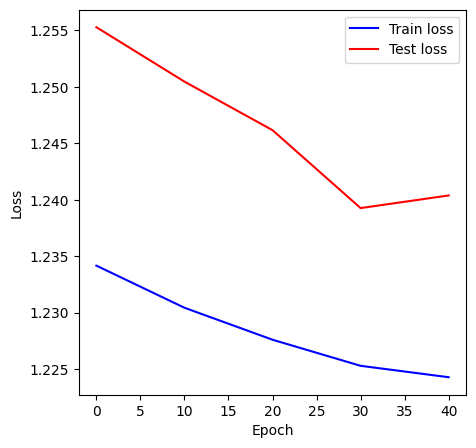

In [62]:
with torch.inference_mode():
    plt.figure(figsize=(5,5))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(epoch_values, train_loss_values, c='b', label='Train loss')
    plt.plot(epoch_values, test_loss_values, c='r', label='Test loss')
    plt.legend()

In [63]:
## Make Prediction

In [64]:
torch.manual_seed(42)
def make_prediction(model :nn.Module,
                    data :torch.Tensor):
    with torch.inference_mode():
        logits = model(data)
        pred = torch.softmax(logits, dim=1).argmax(dim=1)
        return pred

In [65]:
test_pred = make_prediction(model,
                            test_data.data.type(torch.float))

test_pred == test_data.targets

tensor([ True,  True, False,  ..., False, False, False])

In [66]:
## Plot confusion matrix

In [67]:
confusion_matrix = ConfusionMatrix(task='multiclass',
                                   num_classes=len(test_data.classes))
confusion_matrix_tensor = confusion_matrix(preds=test_pred,
                                           target=test_data.targets)
confusion_matrix_tensor

tensor([[757,   0,  25,  94,  38,   0,  81,   2,   0,   3],
        [121,   0,  17, 131, 294, 254,   0,  41,   0, 142],
        [ 16,   0, 538,  10, 413,   0,  23,   0,   0,   0],
        [ 19,   0,  14, 828, 116,   0,  17,   0,   0,   6],
        [  0,   0,  30,  18, 948,   0,   4,   0,   0,   0],
        [  8,   0,   2,   2,  39,   0,   0, 373,   0, 576],
        [144,   0, 113,  64, 519,   0, 157,   0,   0,   3],
        [  0,   0,   0,   0,   0,   0,   0, 868,   0, 132],
        [345,   0,  34,  53, 319,   0,  23,  44,   0, 182],
        [  0,   0,   0,   0,   0,   0,   1,  35,   0, 964]])

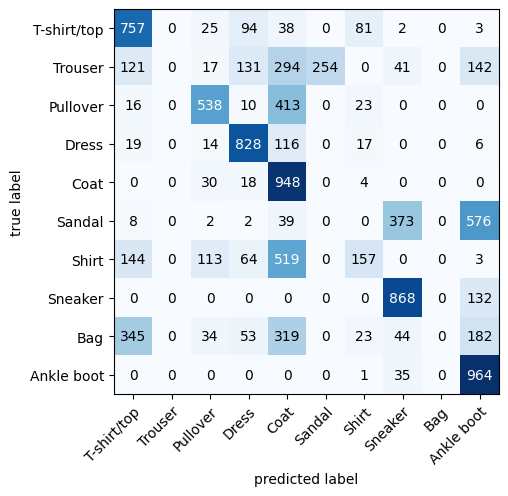

In [68]:
figure, axis = plot_confusion_matrix(
    confusion_matrix_tensor.numpy(),
    class_names=test_data.classes,
    figsize=(5,5)
)

In [74]:
model_path = Path('models')
model_path.mkdir(parents=True,
                 exist_ok=True)
torch.save(obj=model,
           f='/Users/navalmor/Desktop/PyTorch_Learning/computer vision/models/FashionMNISTModel.pt')